## Visualization notebook

This notebook serves to visualize PDFs of the posteriors calculated in make_distributions.ipynb

The main figure in our paper was made with this code

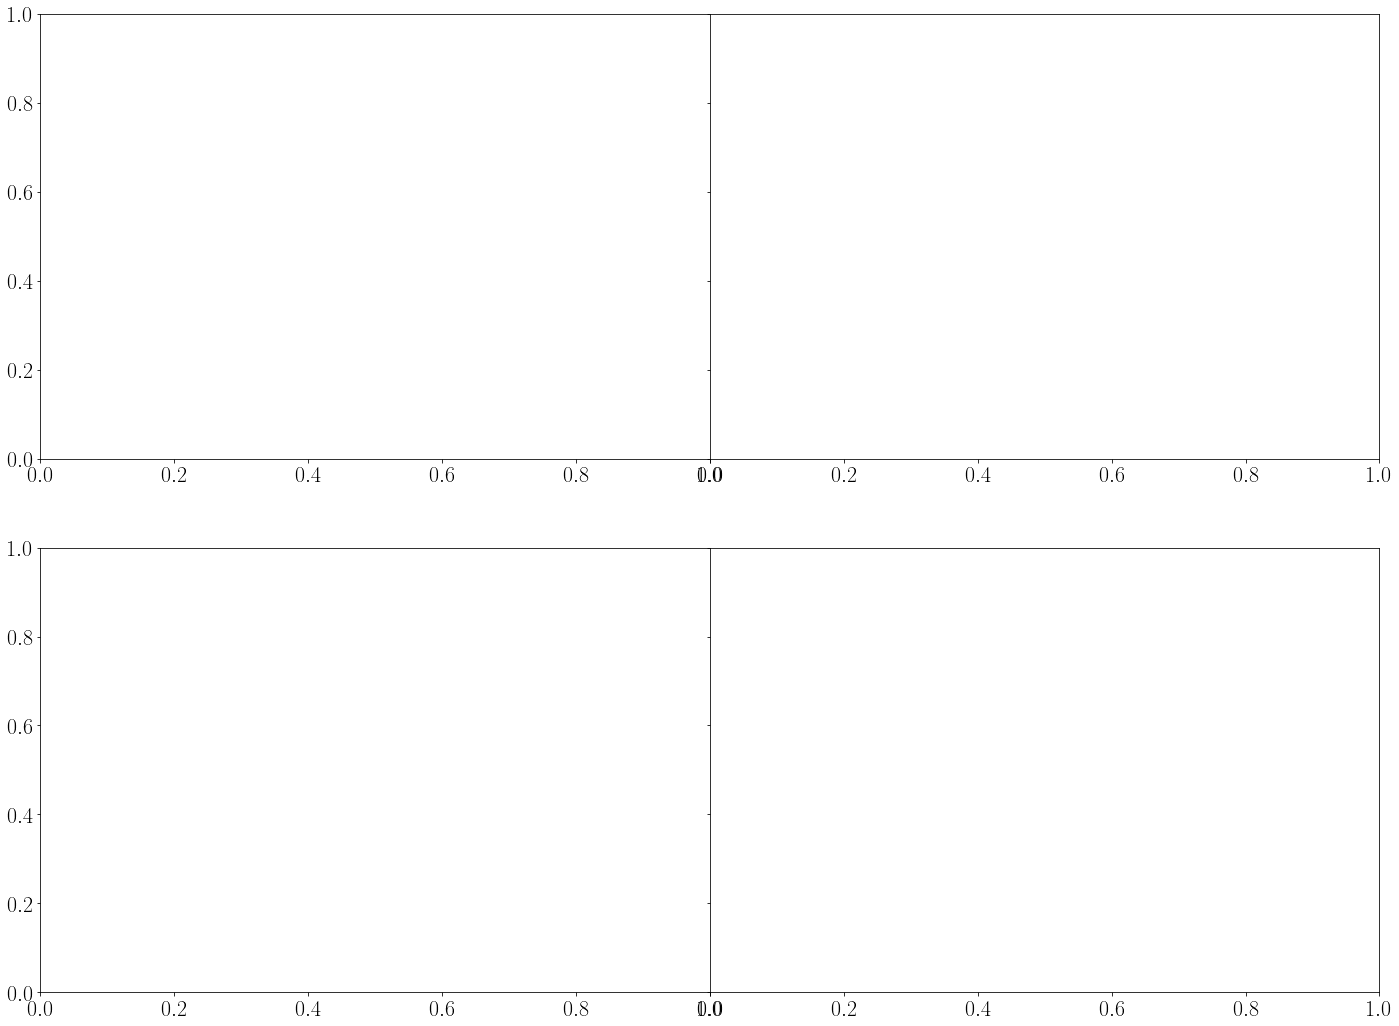

In [10]:
from hmf import functional
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
import matplotlib as mpl
font = {'size'   : 22}

mpl.rc('font', **font)

import numpy as np
import scipy.integrate
import astropy
from astropy.cosmology import LambdaCDM, Planck18_arXiv_v2
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import pickle, time, os

import h5py
import astropy.units as u

#####################################################################
### Install EVS from https://github.com/christopherlovell/evstats ###
#####################################################################

from evstats import evs
from evstats.stats import compute_conf_ints, eddington_bias
from evstats.stellar import apply_fs_distribution

###################################################################################
### From Chris Lovells Extreme Value Statistics paper, arxiv.org/abs/2208.10479 ###
###################################################################################

fig, axs = plt.subplots(nrows = 2, ncols =2, figsize = (2*12,2*9), sharey = True)
plt.subplots_adjust(wspace = 0.0)


In [11]:

############################################################
### See make_distributions.ipynb for further definitions ###
############################################################

cosmo = Planck18_arXiv_v2 # Define cosmology for volume calculation
tot_sky = 41253. # Total square degrees in the sky

halo_model = "SMT"

mmin = 3 # Minimum halo mass for HMF
mmax = 15 # Maximum halo mass for HMF

baryon_frac = 0.0224/0.120 # from Planck18

maxMass = 12.5
dM = 0.5
Nm = 100
mbins = np.arange(3., maxMass+dM/Nm-1e-10, dM/Nm)

c = 'orange'

zs = np.arange(5.5,20,0.5) # z-range, the same as in the cosmic variance datafram

### Figure 1

In [12]:
def plotax(ax, meds, means, sig1s, sig2s, sig3s, xlabel = False, ylabel = True, c='orange',\
           survey = 'CEERS', ty = 'Gamma Sampling', filter_size = 0.25):

    ## Plot mean/median lines
    ax.plot(zs, meds, 'k', linewidth=3, label = 'Median highest mass')
    ax.plot(zs, means, 'k', linestyle = 'dashdot', linewidth=2, label = 'Mean highest mass')

    ## Plot smoothed contours
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig1s)[:,0], filter_size),\
                          gaussian_filter1d(np.vstack(sig1s)[:,1], filter_size), color = c, rasterized = True, alpha=0.7,\
                          label = r'1$\sigma$')
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig2s)[:,0], filter_size),\
                          gaussian_filter1d(np.vstack(sig2s)[:,1], filter_size), color = c, rasterized = True,\
                        alpha=0.3, label = r'2$\sigma$')
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig3s)[:,0], filter_size),\
                          gaussian_filter1d(np.vstack(sig3s)[:,1], filter_size), color = c, rasterized = True,\
                    alpha=0.1, label = r'3$\sigma$')
    
    # set a grid, ylim, xlim and a title
    ax.grid(visible = True,alpha=0.3)
    ax.set(title = f'{survey} from {ty}', ylim = (7,11.5), xlim = (7,19))
    
    ## Whether or not to plot x/y - labels
    if ylabel:
        ax.set(ylabel = r'Max stellar mass [$log(M_*/M_{\odot})$]')
    if xlabel:
        ax.set(xlabel='z')
        
    ## Adjust the label positions of the legend for the contours
    extra_patch = mpatches.Patch(color='white', alpha=0, label='')
    label = ['']
    handles, labels = ax.get_legend_handles_labels()
    handles0 = handles[:2]
    labels0 = labels[:2]
    
    handles0+=[extra_patch]
    labels0+=label
    
    handles = handles0 + handles[2:]
    labels = labels0 + labels[2:]
    
    ax.legend(handles, labels, ncol=2)
    return ax

def lin(x,a = -0.04418885,b = -0.95909967): # extrapolation from Song+ 2016
    return a*x+b

def m_song(Mobs, zobs): # getting mass from M_UV
    return -Mobs/2+lin(zobs)

def M_song(m, zobs): # getting M_UV from mass
    return -2*(m - lin(zobs))

def get_mass(z, zerr, MUV, MUVerr): 
    ''' Method to get mass and mass uncertainty estimate (very uncertain) 
    Input redshift, redshift uncertainty, M_UV and M_UV uncertainty
    
    return mass and mass uncertainty (lower and upper)'''
    
    m = m_song(MUV, z)
    mup = m_song(MUV-MUVerr[1], z-zerr[1])+0.31 # 0.31 dex extra factor, from Jespersen+ 22/ Chuang+ 23
    mlow = m_song(MUV+MUVerr[0], z+zerr[0])-0.31 # 0.31 dex extra factor, from Jespersen+ 22/ Chuang+ 23
    return m, [m-mlow, mup-m]

In [13]:
surveys = ['single', 'ceers']
survey_titles = ['Single JWST Pointing', 'CEERS']
areas = [2*4.84, 33] #in arcminutes 

Nint = 4 #10^(Nint) is the number of samples in the posteriors

plot_points = [True, True] # whether or not to plot the points on a given row

## The papers from which the points came
point_titles = [['Yan+23(SMACS)', 'Naidu+22(GLASS)'], 
                ['Robertson+23(JADES)', 'Fujimoto+23(CEERS)', 'Finkelstein+22(CEERS)']]

## here are the given points redshifts, redshifts uncertainties, M_UV and M_UV uncertainties.

point_z = [[12.47, 12.4], 
        [11.58, 8.807, 16.45]]

point_zerr = [[[0.72, 1.19], [.2, .2]], 
        [[.05, .05], [.003, 0.003], [.48, .18]]]


point_MUV = [[-18.5, -21], 
                [-19.3, -20.44, -21.7]]

point_MUVerr = [[[.1,.1],[.1,.1]], 
                [[.1,.1], [.1,.1], [.1,.1]]]

## what colors to plot the points with
point_colors = ['cyan', 'blue', 'black']

## colors for Gamma sampling, EVS
colors = ['orange', 'green'] 

In [14]:
for n, (survey, area) in enumerate(zip(surveys, areas)):
    
    ## load the CDFs, calculated in make_distributions.ipynb
    cdfs = pickle.load(open(f'posteriors/{survey}_cdfs_{int(Nint)}.pkl', 'rb'))
    
    # loop over the two approaches
    for j, approach in enumerate(['Gamma Sampling', 'EVS']):
        if approach == 'Gamma Sampling':
            
            # initialize lists for statistics
            meds_cdf = []
            sig1s = []
            sig2s = []
            sig3s = []

            for cdf in cdfs: # loop over redshifts, each CDF is at a given redshift
                
                # Get the median
                meds_cdf.append(mbins[np.argmin(abs(cdf-0.5))])
                
                # Get the different sigmas, add more if needed but turn up Ntrials in make_distributions.ipynb first
                sig1s.append([mbins[np.argmin(abs(cdf-norm.cdf(-1)))], mbins[np.argmin(abs(cdf-norm.cdf(1)))]])
                sig2s.append([mbins[np.argmin(abs(cdf-norm.cdf(-2)))], mbins[np.argmin(abs(cdf-norm.cdf(2)))]])
                sig3s.append([mbins[np.argmin(abs(cdf-norm.cdf(-3)))], mbins[np.argmin(abs(cdf-norm.cdf(3)))]])
            
            # Get the mean
            means_cdf = np.array([np.sum(np.diff(cdf)*mbins[:-1]) for cdf in cdfs])
        else: # for EVS
            ## EVS run with SMT + Planck_arXiv_v2 cosmology and same redshift size and mass bin size
            ## See Chris' guide on https://github.com/christopherlovell/evstats
            with h5py.File(os.path.expanduser('posteriors/full_z05.h5'),'r') as hf: 
                log10m = hf['log10m'][:]
                f = hf['f'][:]
                F = hf['F'][:]
                N = hf['N'][:]
                z = hf['z'][:]
            
            ## Adjust the EVS to the correct sky fraction
            whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
            survey_area = area * u.arcmin**2 
            fsky = float(survey_area / whole_sky)
            phi_max = evs._apply_fsky(N, f, F, fsky)

            ## Initialize lists for statistics
            meds_cdf = []
            means_cdf = []
            sig1s = []
            sig2s = []
            sig3s = []
            
            for k in range(len(zs)):
                
                ## EVS is done with halo masses, so have to cast to stellar masses
                z0 = zs[k]
                sbf = 0.05 + 0.024 * (z0 - 4) 
                M1 = log10m+np.log10(baryon_frac)+np.log10(sbf)
                
                # Make CDF from the PDF calculated with EVS
                cdf =  np.cumsum(phi_max[k]*M1)/np.sum(phi_max[k]*M1)

                ## Calculate statistics
                meds_cdf.append(M1[np.argmin(abs(cdf-0.5))])
                
                sig1s.append([M1[np.argmin(abs(cdf-norm.cdf(-1)))], M1[np.argmin(abs(cdf-norm.cdf(1)))]])
                sig2s.append([M1[np.argmin(abs(cdf-norm.cdf(-2)))], M1[np.argmin(abs(cdf-norm.cdf(2)))]])
                sig3s.append([M1[np.argmin(abs(cdf-norm.cdf(-3)))], M1[np.argmin(abs(cdf-norm.cdf(3)))]])
                
                means_cdf.append(np.sum(phi_max[k]*M1)*(M1[1]-M1[0]))
                
    
        ## Here we do the actual plotting of the posteriors
        axs[n][j].cla()
        ax = plotax(axs[n][j], means_cdf, meds_cdf, sig1s, sig2s, sig3s, survey = survey_titles[n],\
                    xlabel = True, ylabel = abs(j-1), c = colors[j], ty = approach)
        
        ## Here we plot the datapoints
        if plot_points[n]:
            for k in range(len(point_zerr[n])):
                
                ## Get mass and plot the masses and uncertainties
                M, Merr = get_mass(point_z[n][k], point_zerr[n][k], point_MUV[n][k], point_MUVerr[n][k])
                
                ## Plot the points
                ax.errorbar(point_z[n][k], M, yerr = np.vstack([Merr]).T, xerr = np.vstack([point_zerr[n][k]]).T,\
                mfc = point_colors[k], marker = 'D', markersize=10.5,\
                ecolor='k', capsize=4, label = point_titles[n][k])
                
                ## Here we adjust the legends of the data points to be properly aligned
                extra_patch = mpatches.Patch(color='white', alpha=0, label='')
                label = ['']          
                handles, labels = ax.get_legend_handles_labels()
                handles0 = handles[:2]
                labels0 = labels[:2]

                handles0 += [extra_patch]
                labels0 += label

                handles = handles0 + handles[2:]
                labels = labels0 + labels[2:]
                ax.legend(handles, labels, ncol=3, fontsize = 18)

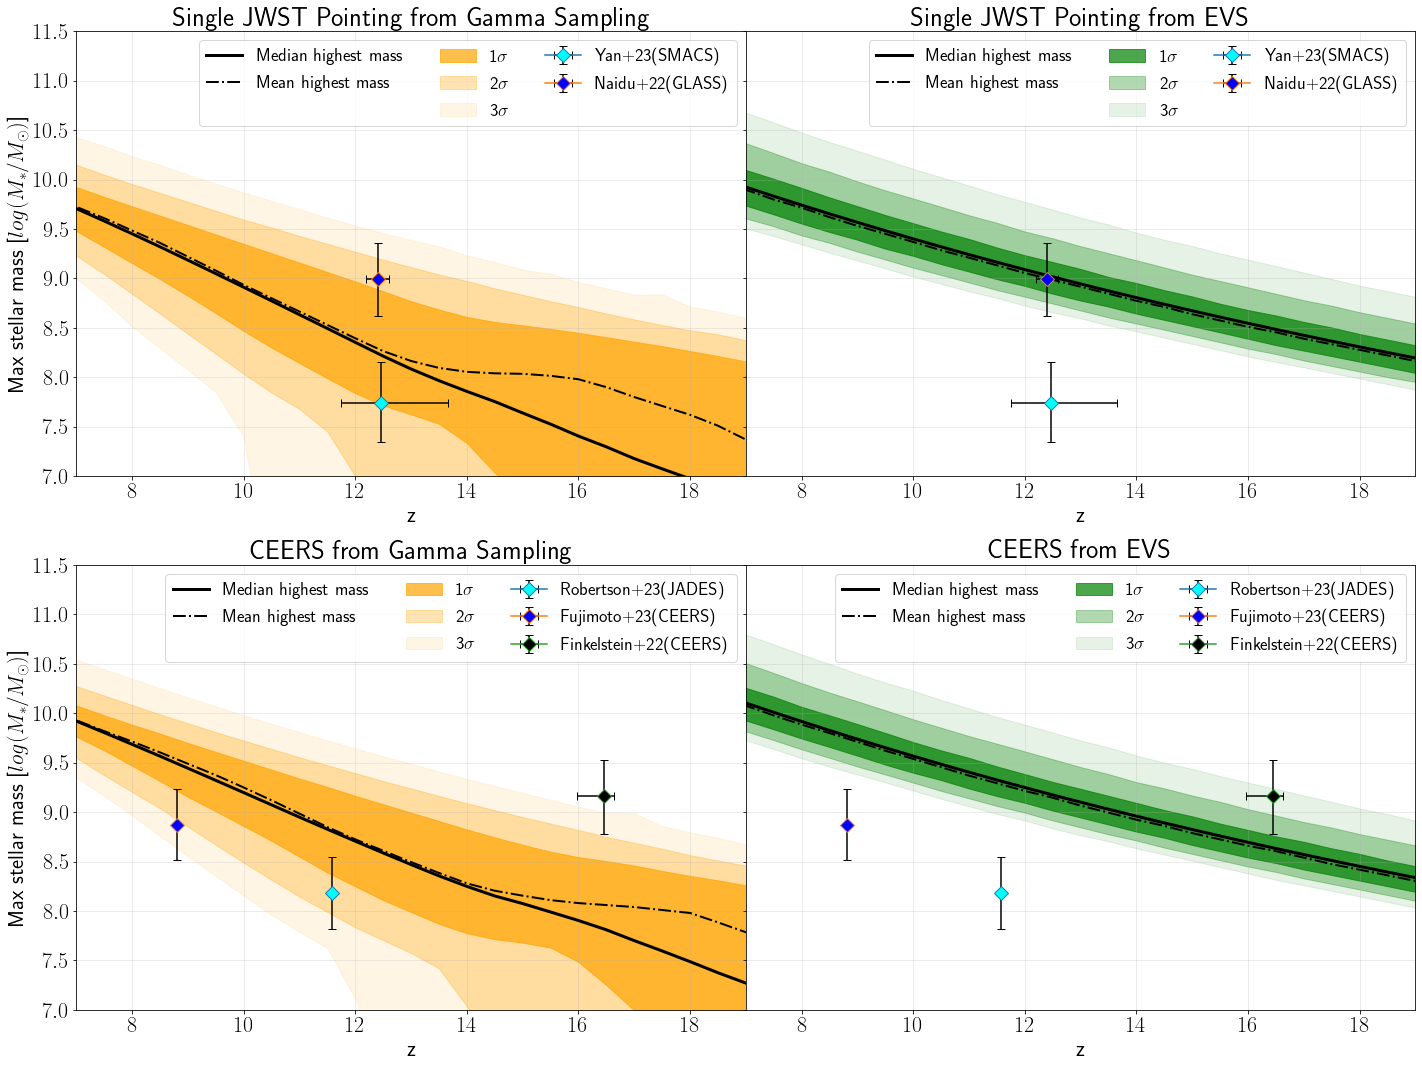

In [15]:
fig

In [18]:
# fig.savefig('figs/single_most_massive_distribution.png')